In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [16]:
pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 5.4 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for tzlocal from https://files.pythonhosted.org/packages/97/3f/c4c51c55ff8487f2e6d0e618dba917e3c3ee2caae6cf0fbb59c9b1876f2e/tzlocal-5.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


### Load Dataset

In [2]:
workflows_df = pd.read_csv("workf\low_dataset/workflows.csv.gz")
workflows_df

FileNotFoundError: [Errno 2] No such file or directory: 'workf\\low_dataset/workflows.csv.gz'

In [31]:
df_lint_response = pd.read_json('workflow_dataset/actionresponsecheck.json', lines=True)
df_lint_response['workflow_content'] = df_lint_response["filepath"].str.rsplit(".", n=1).str[0]
df_lint_response

,message,filepath,line,column,kind,snippet,end_column,workflow_content
0,"duplicate value {""ros_distro"": ""noetic"", ""prer...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,164,13,matrix,"- {ROS_DISTRO: noetic, PRERELEASE: t...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...
1,"duplicate value {""ros_distro"": ""noetic"", ""ubun...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,165,13,matrix,"- {ROS_DISTRO: noetic, UBUNTU: 20.04...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...
2,"property ""depth"" is not defined in object type...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,254,27,expression,fetch-depth: ${{matrix.depth}}\n ...,40,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...
3,"workflow command ""set-env"" was deprecated. use...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...
4,"workflow command ""add-path"" was deprecated. us...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...
...,...,...,...,...,...,...,...,...
1128534,"unexpected key ""description"" for ""workflow"" se...",ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,2,1,syntax-check,description: Sets environment variables for th...,12,ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...
1128535,"unexpected key ""inputs"" for ""workflow"" section...",ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,4,1,syntax-check,inputs:\n^~~~~~~,7,ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...
1128536,"unexpected key ""runs"" for ""workflow"" section. ...",ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,9,1,syntax-check,runs:\n^~~~~,5,ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...
1128537,"workflow command ""set-output"" was deprecated. ...",fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,34,14,deprecated-commands,run: |\n ^,14,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...


In [41]:
with open('workflow_dataset/workflow_line_info.json', 'r') as datafile:
    data = json.load(datafile)
    df_workflow_line_count = pd.DataFrame([data])
    df_workflow_line_count = df_workflow_line_count.T

df_workflow_line_count.rename(columns = {0:'lines_count'}, inplace = True)
df_workflow_line_count['workflow_content'] = df_workflow_line_count.index.str.rsplit(".", n=1).str[0]

### Merging Dataset

In [32]:
df = pd.merge(df_lint_response, workflows_df, how ="inner", on="workflow_content")
df

,message,filepath,line,column,kind,snippet,end_column,workflow_content,repository,commit,author_name,author_email,commiter_name,commiter_email,date,workflow,change_type
0,"duplicate value {""ros_distro"": ""noetic"", ""prer...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,164,13,matrix,"- {ROS_DISTRO: noetic, PRERELEASE: t...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,1666292969,.github/workflows/main.yml,M
1,"duplicate value {""ros_distro"": ""noetic"", ""ubun...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,165,13,matrix,"- {ROS_DISTRO: noetic, UBUNTU: 20.04...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,1666292969,.github/workflows/main.yml,M
2,"property ""depth"" is not defined in object type...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,254,27,expression,fetch-depth: ${{matrix.depth}}\n ...,40,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,1666292969,.github/workflows/main.yml,M
3,"workflow command ""set-env"" was deprecated. use...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...,replicatedhq---troubleshoot,890cbb1378fadc3fd8a19dec78e6814a56570852,Marc Campbell,marc.e.campbell@gmail.com,GitHub,noreply@github.com,1591994460,.github/workflows/build-test-deploy.yaml,M
4,"workflow command ""add-path"" was deprecated. us...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...,replicatedhq---troubleshoot,890cbb1378fadc3fd8a19dec78e6814a56570852,Marc Campbell,marc.e.campbell@gmail.com,GitHub,noreply@github.com,1591994460,.github/workflows/build-test-deploy.yaml,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304194,"unexpected key ""runs"" for ""workflow"" section. ...",ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,9,1,syntax-check,runs:\n^~~~~,5,ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,elementor---elementor,dd2c390b8b4ad5cde63a11c0b6569a70edd89129,Tzvi Rabinovitch,tzvir@elementor.com,Tzvi Rabinovitch,tzvir@elementor.com,1677160730,.github/workflows/env-vars-configure/action.yml,A
1304195,"workflow command ""set-output"" was deprecated. ...",fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,34,14,deprecated-commands,run: |\n ^,14,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,f85fbaac7cf54b5729ad6e522e9012e263336994,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,1666898529,.github/workflows/tests.yml,D
1304196,"workflow command ""set-output"" was deprecated. ...",fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,34,14,deprecated-commands,run: |\n ^,14,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,6ef4455b2dd7be35b0627f785babf21ef5f4b05b,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,1665770340,.github/workflows/tests.yml,M
1304197,property access of object must be type of stri...,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,72,52,expression,DB_PORT: ${{ job.services.database.p...,56,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,f85fbaac7cf54b5729ad6e522e9012e263336994,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,1666898529,.github/workflows/tests.yml,D


In [43]:
df = pd.merge(df, df_workflow_line_count, how ="inner", on="workflow_content")
df

,message,filepath,line,column,kind,snippet,end_column,workflow_content,repository,commit,author_name,author_email,commiter_name,commiter_email,date,workflow,change_type,commit_year,lines_count
0,"duplicate value {""ros_distro"": ""noetic"", ""prer...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,164,13,matrix,"- {ROS_DISTRO: noetic, PRERELEASE: t...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,2022-10-20 21:09:29,.github/workflows/main.yml,M,2022,261
1,"duplicate value {""ros_distro"": ""noetic"", ""ubun...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,165,13,matrix,"- {ROS_DISTRO: noetic, UBUNTU: 20.04...",24,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,2022-10-20 21:09:29,.github/workflows/main.yml,M,2022,261
2,"property ""depth"" is not defined in object type...",00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,254,27,expression,fetch-depth: ${{matrix.depth}}\n ...,40,00003c6d833c8905e8d4fa77685fca67ed234cdf1997ed...,ros-industrial---industrial_ci,a9b1bb2f240c9f142c0f61db7b2789eeb2409367,Robert Haschke,rhaschke@techfak.uni-bielefeld.de,Mathias Lüdtke,727227+mathias-luedtke@users.noreply.github.com,2022-10-20 21:09:29,.github/workflows/main.yml,M,2022,261
3,"workflow command ""set-env"" was deprecated. use...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...,replicatedhq---troubleshoot,890cbb1378fadc3fd8a19dec78e6814a56570852,Marc Campbell,marc.e.campbell@gmail.com,GitHub,noreply@github.com,2020-06-12 22:41:00,.github/workflows/build-test-deploy.yaml,M,2020,133
4,"workflow command ""add-path"" was deprecated. us...",00005cf149b2465e44262a2c1552b63426f70c8188c213...,20,14,deprecated-commands,run: |\n ^,14,00005cf149b2465e44262a2c1552b63426f70c8188c213...,replicatedhq---troubleshoot,890cbb1378fadc3fd8a19dec78e6814a56570852,Marc Campbell,marc.e.campbell@gmail.com,GitHub,noreply@github.com,2020-06-12 22:41:00,.github/workflows/build-test-deploy.yaml,M,2020,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304194,"unexpected key ""runs"" for ""workflow"" section. ...",ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,9,1,syntax-check,runs:\n^~~~~,5,ffffee32a04a382e12ba2c1e8bfac865c66f79d50257f6...,elementor---elementor,dd2c390b8b4ad5cde63a11c0b6569a70edd89129,Tzvi Rabinovitch,tzvir@elementor.com,Tzvi Rabinovitch,tzvir@elementor.com,2023-02-23 14:58:50,.github/workflows/env-vars-configure/action.yml,A,2023,41
1304195,"workflow command ""set-output"" was deprecated. ...",fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,34,14,deprecated-commands,run: |\n ^,14,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,f85fbaac7cf54b5729ad6e522e9012e263336994,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,2022-10-27 21:22:09,.github/workflows/tests.yml,D,2022,73
1304196,"workflow command ""set-output"" was deprecated. ...",fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,34,14,deprecated-commands,run: |\n ^,14,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,6ef4455b2dd7be35b0627f785babf21ef5f4b05b,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,2022-10-14 19:59:00,.github/workflows/tests.yml,M,2022,73
1304197,property access of object must be type of stri...,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,72,52,expression,DB_PORT: ${{ job.services.database.p...,56,fffff83d87c8c15d57723d8555e9fa6824e1585ab5f03e...,jexactyl---jexactyl,f85fbaac7cf54b5729ad6e522e9012e263336994,cmrxnn,cmrxn2005@gmail.com,cmrxnn,cmrxn2005@gmail.com,2022-10-27 21:22:09,.github/workflows/tests.yml,D,2

### Adding some more features

In [48]:
df['date'] = df['date'].apply(lambda x: datetime.fromtimestamp(x))
df['commit_year'] = pd.DatetimeIndex(df['date']).year
df['commit_mon_year'] = pd.DatetimeIndex(df['date']).to_period('M')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1304199 entries, 0 to 1304198
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   message           1304199 non-null  object        
 1   filepath          1304199 non-null  object        
 2   line              1304199 non-null  int64         
 3   column            1304199 non-null  int64         
 4   kind              1304199 non-null  object        
 5   snippet           1301577 non-null  object        
 6   end_column        1304199 non-null  int64         
 7   workflow_content  1304199 non-null  object        
 8   repository        1304199 non-null  object        
 9   commit            1304199 non-null  object        
 10  author_name       1304199 non-null  object        
 11  author_email      1304107 non-null  object        
 12  commiter_name     1304199 non-null  object        
 13  commiter_email    1304107 non-null  object

In [59]:
df_group = df.groupby(['commit_mon_year'])['commit_mon_year'].count()
df_group

commit_mon_year
2019-07       34
2019-08      617
2019-09     1368
2019-10     2274
2019-11     2712
2019-12     4229
2020-01     6055
2020-02     7594
2020-03     8687
2020-04    10603
2020-05    11442
2020-06    14296
2020-07    15525
2020-08    17056
2020-09    17708
2020-10    23971
2020-11    19964
2020-12    19642
2021-01    21005
2021-02    78922
2021-03    24045
2021-04    86080
2021-05    23680
2021-06    21771
2021-07    22579
2021-08    22113
2021-09    24521
2021-10    27842
2021-11    30667
2021-12    28979
2022-01    28806
2022-02    27379
2022-03    39782
2022-04    36078
2022-05    36937
2022-06    37054
2022-07    33256
2022-08    38150
2022-09    38093
2022-10    42101
2022-11    32549
2022-12    30673
2023-01    29861
2023-02    31144
2023-03    45911
2023-04    27831
2023-05    30178
2023-06    27720
2023-07    26570
2023-08    25400
2023-09    31395
2023-10    11350
Freq: M, Name: commit_mon_year, dtype: int64

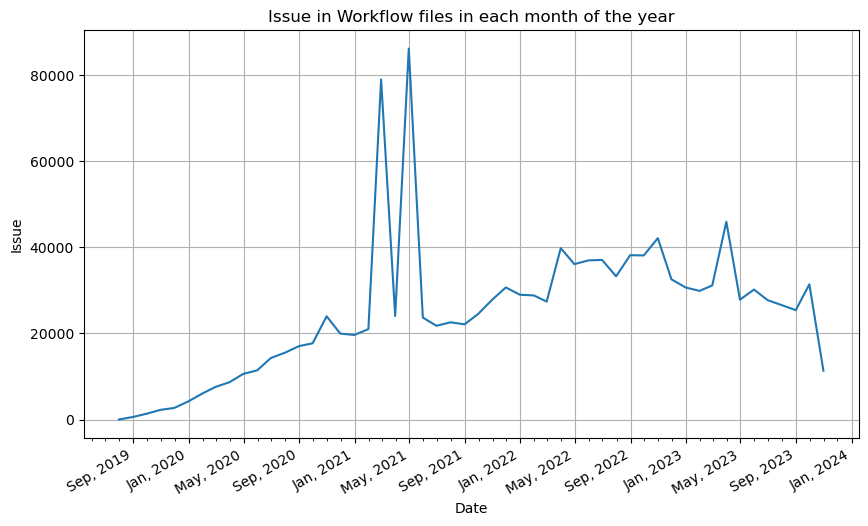

In [60]:
# Convert Date column to numeric value
dates = mdates.date2num(df_group.index)

fig, ax = plt.subplots(figsize=(10, 6))
# fig(figsize=(8, 6), dpi=80)
ax.plot(dates, df_group.values, markersize=12)
ax.set_title('Issue in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')
# ax.legend()
# Add the grid
plt.grid(True)
# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)


half_year_locator = mdates.MonthLocator(interval=4)
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)


plt.gcf().autofmt_xdate()

plt.show()

In [61]:
df['kind'].value_counts()

deprecated-commands    543532
expression             292206
syntax-check           217987
runner-label           134139
yaml-syntax             37298
matrix                  23520
events                  18617
action                  15106
pyflakes                 8648
glob                     7119
job-needs                3252
id                       1347
shell-name                632
env-var                   401
permissions               235
workflow-call             160
Name: kind, dtype: int64

In [71]:
df_group_kind = df.groupby(['kind','commit_mon_year'], as_index=False).size()
df_group_kind

,kind,commit_mon_year,size
0,action,2019-08,59
1,action,2019-09,73
2,action,2019-10,95
3,action,2019-11,109
4,action,2019-12,122
...,...,...,...
726,yaml-syntax,2023-06,325
727,yaml-syntax,2023-07,285
728,yaml-syntax,2023-08,389
729,yaml-syntax,2023-09,296


In [67]:
df_group_kind = df.groupby(['kind','commit_mon_year'], as_index=False).size()
df_group_kind

,kind,commit_mon_year,size
0,action,2019-08,59
1,action,2019-09,73
2,action,2019-10,95
3,action,2019-11,109
4,action,2019-12,122
...,...,...,...
726,yaml-syntax,2023-06,325
727,yaml-syntax,2023-07,285
728,yaml-syntax,2023-08,389
729,yaml-syntax,2023-09,296


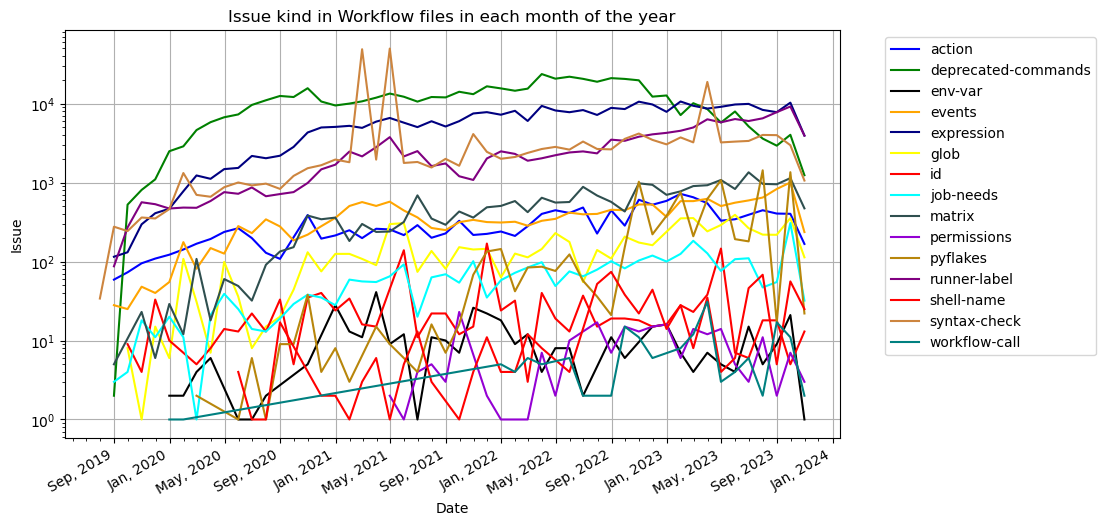

In [72]:
kinds = df_group_kind['kind'].unique()
colors = [
    'blue', 'green', 'black', 'orange', 'navy',
    'yellow', 'red', 'cyan', 'darkslategray', 'darkviolet',
    'darkgoldenrod', 'purple', 'red', 'peru', 'teal'
]

fig, ax = plt.subplots(figsize=(10, 6))

for kind, color in zip(kinds, colors):
    data = df_group_kind[df_group_kind['kind'] == kind]
    ax.plot(mdates.date2num(data.commit_mon_year.values), data['size'].values, color=color, label=kind)

ax.set_title('Issue kind in Workflow files in each month of the year')
ax.set_xlabel('Date')
ax.set_ylabel('Issue')
plt.yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.grid(True)

# Format x-axis labels as dates
date_form = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(date_form)

half_year_locator = mdates.MonthLocator(interval=4)
monthly_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_minor_locator(monthly_locator)

plt.gcf().autofmt_xdate()
plt.show()

In [76]:
df_group_count = df.groupby(['workflow','lines_count'], as_index=False).size().sort_values(by='size',ascending = False)

In [77]:
df_group_count

,workflow,lines_count,size
119202,.github/workflows/pytest-durations.json,5151,10304
155250,build_tooling/pytest-durations.json,5151,5152
125438,.github/workflows/release.yml,742,1344
57948,.github/workflows/ci.yaml,3780,930
57964,.github/workflows/ci.yaml,5090,888
...,...,...,...
60187,.github/workflows/ci_test-base.yml,103,1
60178,.github/workflows/ci_test-base.yml,90,1
60172,.github/workflows/ci_templates.yml,97,1
121458,.github/workflows/rebase-bot.yml,17,1


Text(0, 0.5, 'Number of Lines')

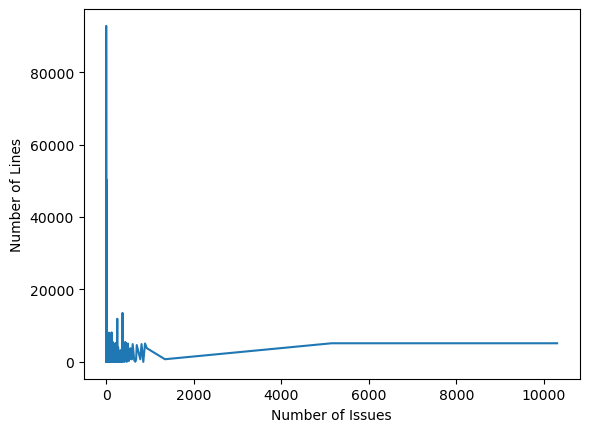

In [80]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(df_group_count['size'], df_group_count['lines_count']);
plt.xlabel('Number of Issues')
plt.ylabel('Number of Lines')


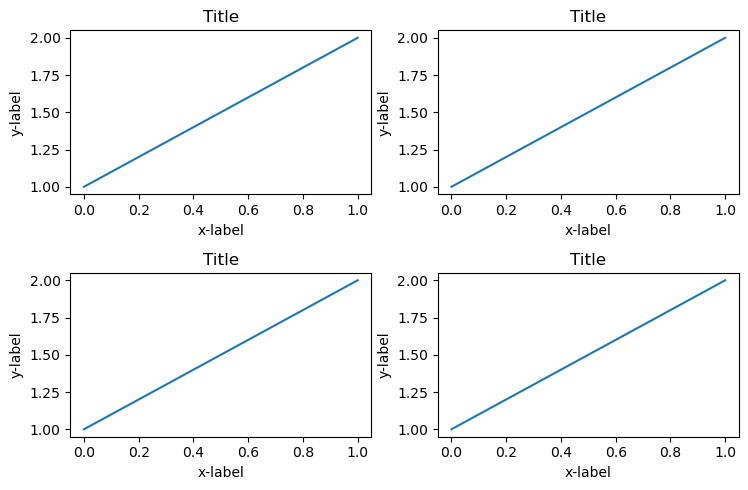

In [81]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7.5,5), 'figure.dpi':100})
def plotnew(ax):
    ax.plot([1,2])
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    ax.set_title('Title')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
plotnew(ax1)
plotnew(ax2)
plotnew(ax3)
plotnew(ax4)
plt.tight_layout()


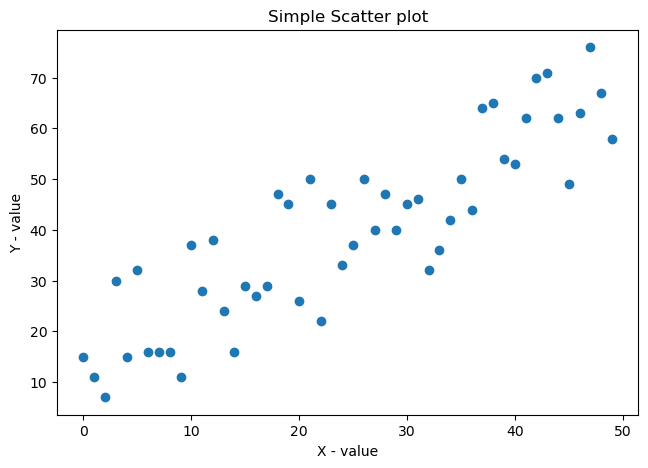

In [82]:
# Simple Scatterplot
x = range(50)
y = range(50) + np.random.randint(0,30,50)
plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Simple Scatter plot')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

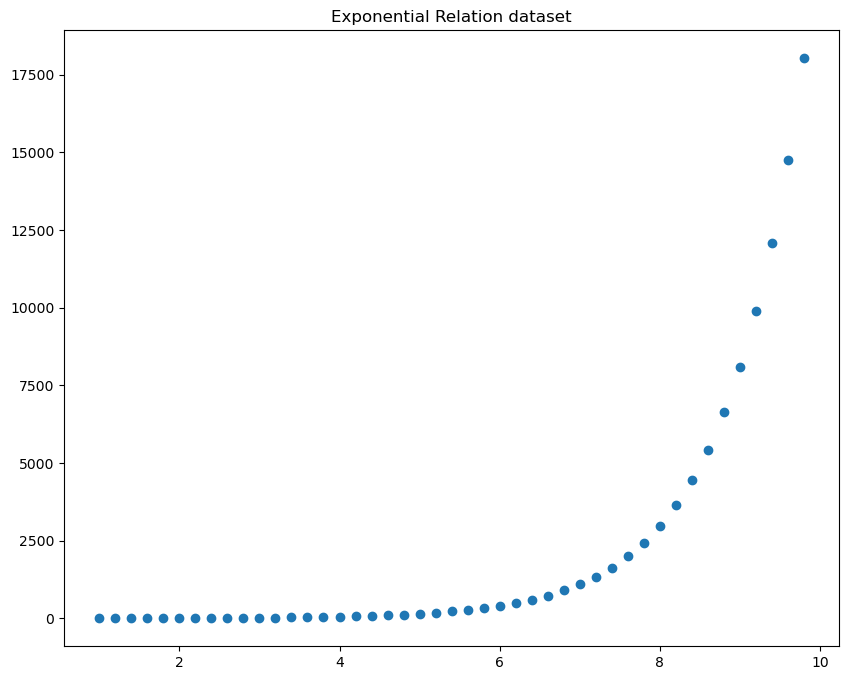

In [83]:
# Scatterplot of non-random vzriables
x=np.arange(1,10,0.2)
y= np.exp(x)
plt.scatter(x,y)
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('Exponential Relation dataset')
plt.show()

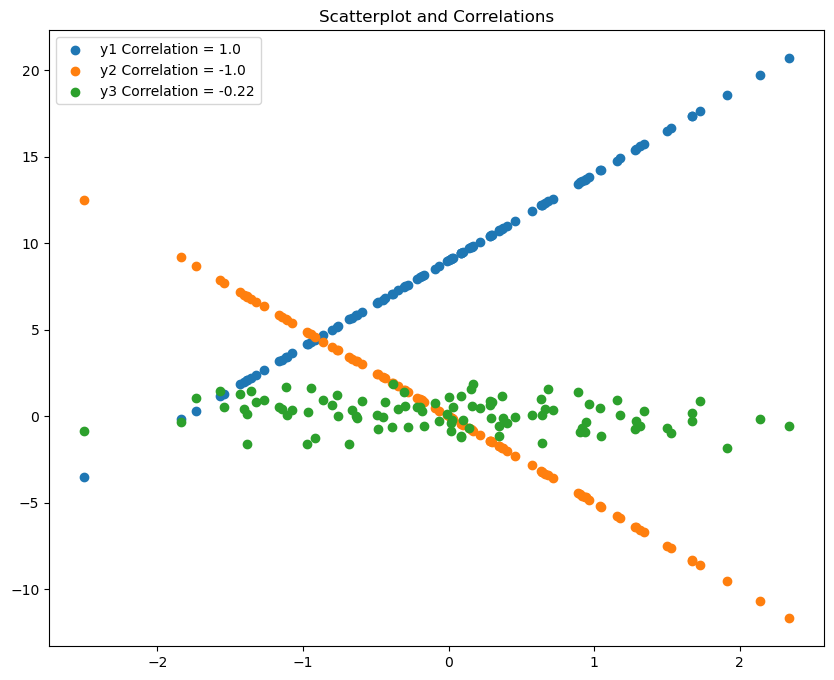

In [84]:
# Scatterplot and Correlations
# Data
x=np.random.randn(100)
y1= x*5 +9 
y2= -5*x
y3=np.random.randn(100)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y1, label=f'y1 Correlation = {np.round(np.corrcoef(x,y1)[0,1], 2)}')
plt.scatter(x, y2, label=f'y2 Correlation = {np.round(np.corrcoef(x,y2)[0,1], 2)}')
plt.scatter(x, y3, label=f'y3 Correlation = {np.round(np.corrcoef(x,y3)[0,1], 2)}')

# Plot
plt.title('Scatterplot and Correlations')
plt.legend()
plt.show()

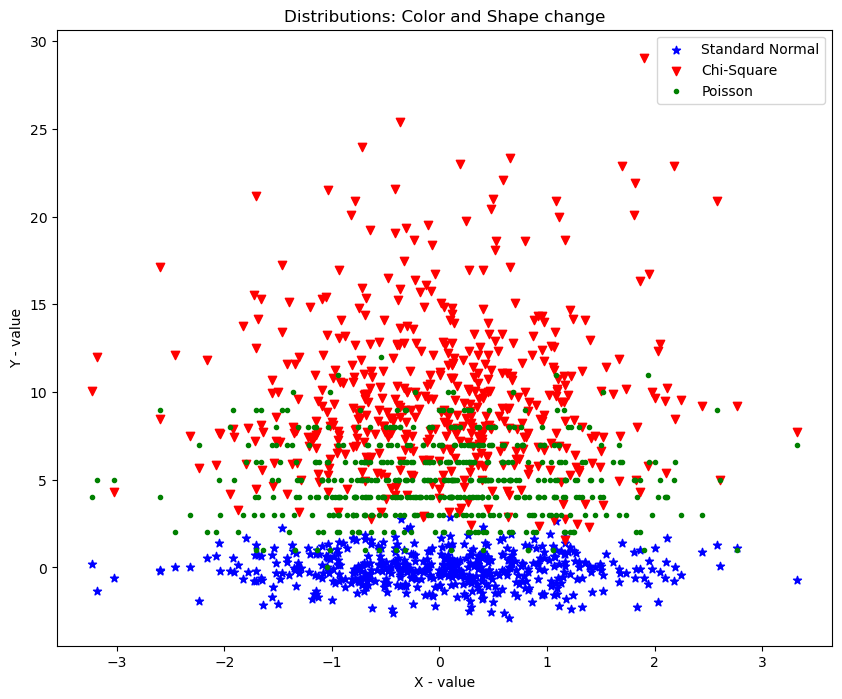

In [85]:
# Scatterplot of different distributions. Color and Shape of Points.
x = np.random.randn(500)
y1 = np.random.randn(500)
y2 = np.random.chisquare(10, 500)
y3 = np.random.poisson(5, 500)

# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x,y1,color='blue', marker= '*', label='Standard Normal')
plt.scatter(x,y2,color= 'red', marker='v', label='Chi-Square')
plt.scatter(x,y3,color= 'green', marker='.', label='Poisson')


# Decorate
plt.title('Distributions: Color and Shape change')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.legend(loc='best')
plt.show()

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_51258/2557530208.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['A'], hist=True, kde=True,


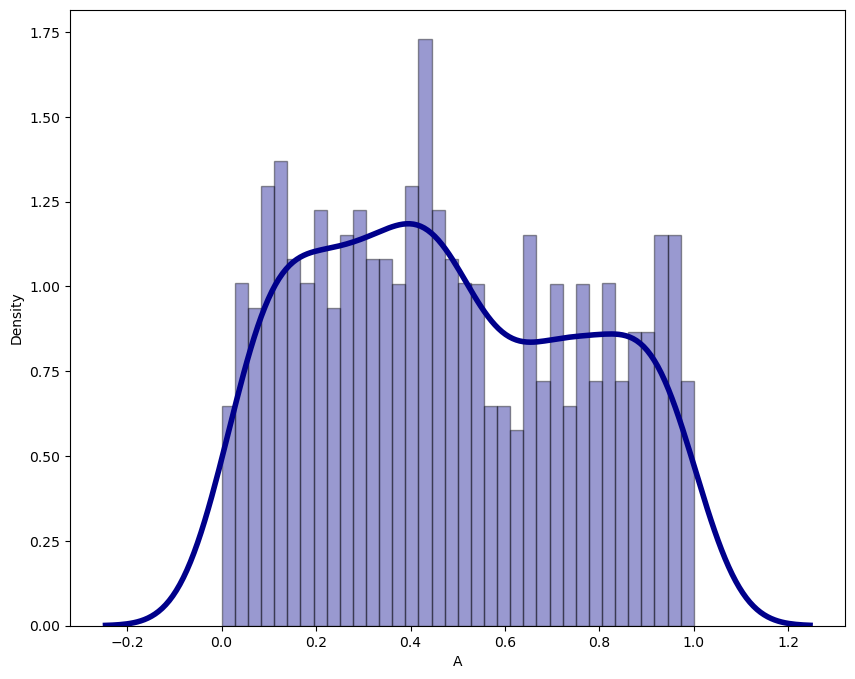

In [87]:
import seaborn as sns

df1 = pd.DataFrame(np.random.rand(500, 1), columns=['A'])
sns.distplot(df1['A'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});